In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import re
from datetime import datetime
import pickle
from sklearn.linear_model import ElasticNet
import gc

#from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [23]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.precio.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['precio'], axis=1, inplace=True)

In [24]:
#dropping the texts columns, the redudant ones,  and the one that have too many nan values.
cleanedData = all_data.drop(columns = ['direccion','titulo','descripcion','centroscomercialescercanos'])

cleanedData.index = cleanedData['id']
cleanedData.drop(columns = ['id'], inplace = True)

# tipo de propiedad 

In [25]:
# need to be modified to match the words and not part of it
#tipo de propiedad, fill depending on title and descriptions, title > description
for x in all_data[all_data['tipodepropiedad'].isnull()][['titulo','descripcion','id']].values:
    if(type(x[1])!= str):
        x[1] = ""

    b = []
    for y in all_data['tipodepropiedad'].drop_duplicates().dropna().values:
        if y.lower() in (x[0].lower()+x[1].lower()):
            b = [y]
    
    if (len(b)!=0):
        #use x[0] or the following or define priorities...
        #c = train[train['tipodepropiedad'].isin(b)]['tipodepropiedad'].mode()
        cleanedData.loc[x[2],'tipodepropiedad'] = b[0]
        #print(b)
#We should drop the remaining values.

if(cleanedData['tipodepropiedad'].isnull().sum() == 0):
    print("Every values is fixed")
else:
    print((all_data['tipodepropiedad'].isnull().sum()-cleanedData['tipodepropiedad'].isnull().sum()),"values fixed")
    print(all_data['tipodepropiedad'].isnull().sum(),"left")

44 values fixed
53 left


# propiedad

In [26]:
#provincia, fill depending on title and descriptions, title > description
for x in all_data[all_data['provincia'].isnull()][['titulo','descripcion','id']].values:
    if(type(x[1])!= str):#get rid of nan descriptions
        x[1] = ""
    if(type(x[0])!=str):#get rid of nan titles
        x[0]=""
        
    b = []
    for y in all_data['provincia'].drop_duplicates().dropna().values:
        if y.lower() in (x[0].lower()+x[1].lower()):
            b = [y]
    
    if (len(b)!=0):
        cleanedData.loc[x[2],'provincia'] = b[0]
    #else:
    #    cleanedData.loc[x[2],'provincia'] = all_data['provincia'].mode().values[0]
#We should drop the remaining values.

#fix other knowing there lat/lng location
distance = lambda a,b,c,d: ((a-c)**2+(b-d)**2)**(1/2)

# SE ARMA UN DF CON ['lat','lng','provincia'], LO AGRUPA POR PROVINCIA Y SACA  EL PROMEDIO DE LAT Y LNG
# LUEGO RECORRE EL DF CON provincia QUE SON NULL Y COMPARA SU (LAT,LNG) Y ENCUENTRA LA PROVINCIA MAS CERCANA
# EN BASE A LOS PROMEDIOS QUE TIENE ARMADO DE LOS (LAT,LNG) DE LAS PROVINCIAS.
#
# PARA MI PUEDE ESTAR MUY ERRADO ESTE APPROACH, MAS CUANDO ESTAS AVERIGUANDO UN (LAT,LNG) QUE ESTA CERCA DE LA
# FRONTERA CON OTRA PROVINCIA.

meanProv = train[['lat','lng','provincia']].groupby('provincia').mean().dropna()

# ARMA EL all_data[['lat','lng','id']] LUEGO BUSCA LOS QUE TIENE PROVINCIA NULL ([all_data['provincia'].isnull()])
# Y DE ESE RESULTADO BUSCA LOS QUE LA 'LAT' ES NO NULL [all_data['lat'].notnull()]
for x in all_data[['lat','lng','id']][all_data['provincia'].isnull()][all_data['lat'].notnull()].values:
    #find the closest city
    dist = [distance(x[0],x[1],y[0],y[1]) for y in meanProv.values]
    cleanedData.loc[x[2],'provincia'] = meanProv.index[np.argmin(dist)]

if(cleanedData['provincia'].isnull().sum() == 0):
    print("Every values is fixed")
else:
    print("%.2f"%((1-cleanedData['provincia'].isnull().sum()/all_data['provincia'].isnull().sum())*100),"% of values fixed")        
    print(cleanedData['provincia'].isnull().sum(),"left")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25.89 % of values fixed
146 left


# Ciudad

In [27]:
#next line to solve warning?
#df[df.index.isin(a_list) & df.a_col.isnull()]
#ciudad, fill depending on title and descriptions, title > description
for x in all_data[all_data['ciudad'].isnull()][['titulo','descripcion','id']].values:
    if(type(x[1])!= str):
        x[1] = ""
    if(type(x[0])!=str):#get rid of nan titles
        x[0]=""
    
    CiudadList = list(all_data['ciudad'].drop_duplicates().dropna().values)
    CiudadList.remove("Casas")
    
    b = [y for y in CiudadList if y.lower() in (x[0].lower()+x[1].lower())]
    
    if (len(b)!=0):
        cleanedData.loc[x[2],'ciudad'] = b[0]
    #else:
    #    cleanedData.loc[x[2],'ciudad'] = all_data['ciudad'].mode().values[0]
#We should drop the remaining values.

#fix other knowing there lat/lng location
distance = lambda a,b,c,d: ((a-c)**2+(b-d)**2)**(1/2)

# SE ARMA UN DF CON ['lat','lng','ciudad'], LO AGRUPA POR ciudad Y SACA  EL PROMEDIO DE LAT Y LNG
# LUEGO RECORRE EL DF CON ciudad QUE SON NULL Y COMPARA SU (LAT,LNG) Y ENCUENTRA LA ciudad MAS CERCANA
# EN BASE A LOS PROMEDIOS QUE TIENE ARMADO DE LOS (LAT,LNG) DE LAS ciudades.
#
# PARA MI PUEDE ESTAR MUY ERRADO ESTE APPROACH, MAS CUANDO ESTAS AVERIGUANDO UN (LAT,LNG) QUE ESTA CERCA DE LA
# FRONTERA CON OTRA ciudad.

meanCiudades = train[['lat','lng','ciudad']].groupby('ciudad').mean().dropna()
for x in all_data[['lat','lng','id']][all_data['ciudad'].isnull()][all_data['lat'].notnull()].values:
    #find the closest city
    dist = [distance(x[0],x[1],y[0],y[1]) for y in meanCiudades.values]
    cleanedData.loc[x[2],'ciudad'] = meanCiudades.index[np.argmin(dist)]

if(cleanedData['ciudad'].isnull().sum() == 0):
    print("every values is fixed")
else:
    print("%.2f"%((1-cleanedData['ciudad'].isnull().sum()/all_data['ciudad'].isnull().sum())*100),"% of values fixed")        
    print(cleanedData['ciudad'].isnull().sum(),"left")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


72.31 % of values fixed
126 left


# metrostotales & metroscubiertos 

In [49]:
# ES SUBJETIVO COMO HACE EL DATA CLEANING PARA MI. 
# ES DECIR SU TECNICA NO GARANTIZA QUE LOS VALORES QUE DEDUCE SEAN CORRECTOS 
# NI TAMPOCO QUE LOS QUE NO ENCUENTRA REALMENTE NO SE PUEDAN INFERIR DE LAS COLUMNAS ANALIZADAS

# Id Zona 

In [28]:
ciudadMexico = pd.concat(pd.read_excel("CPdescarga.xls", sheet_name=None), ignore_index=True, sort = False)
ciudadMexico = ciudadMexico[["d_codigo","D_mnpio","d_CP","d_zona"]].dropna().drop_duplicates()

ciudades = ciudadMexico[['d_codigo','d_zona','D_mnpio']].dropna()['D_mnpio'].unique()
print("Gives information for %.2f"%(len(set(all_data['ciudad'].unique()).intersection(ciudades))/len(all_data['ciudad'].unique())*100),"% of the cities")

Gives information for 95.44 % of the cities


In [29]:
#first fill with the new dataset we have
CP_dict = ciudadMexico.groupby('D_mnpio').first()['d_CP'].to_dict()
cleanedData.idzona = cleanedData.idzona.fillna(cleanedData.ciudad.map(CP_dict))

In [30]:
#then fill using comparisons with other geographical points.
meanCiudades = train[['lat','lng','ciudad']].groupby('ciudad').mean().dropna()
meanIDZona = all_data[['lat','lng','idzona']].groupby('idzona').mean().dropna()
for x in all_data[['lat','lng','id']][cleanedData['idzona'].isnull()][cleanedData['lat'].notnull()].values:
    #find the closest city
    dist = [distance(x[0],x[1],y[0],y[1]) for y in meanCiudades.values]
    cleanedData.loc[x[2],'idzona'] = meanIDZona.index[np.argmin(dist)]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [31]:
if(cleanedData['idzona'].isnull().sum() == 0):
    print("Every values is fixed")
else:
    print("%.2f"%((1-cleanedData['idzona'].isnull().sum()/all_data['idzona'].isnull().sum())*100),"% of values fixed")

92.30 % of values fixed


In [32]:
cleanedData["idzona"].fillna(cleanedData["idzona"].mode()[0], inplace = True)

In [33]:
#drop lat lng as we do not need those anymore
cleanedData.drop(columns = ['lat','lng'], inplace = True)

# Garages 

In [ ]:
numberList = ["dos","tres","cuatro","cinco","seis","siete","nueve","diez","once","doce",
             "1","2","3","4","5","6","7","8","9","10","11","12","13"]

In [ ]:
# CONCATENA numberList CON EL ARR ['garage', 'garages'] Y CON TODAS ESAS VARIANTES SE FIJA SI PARA LAS ROWS
# QUE NO TIENEN GARAGE , TIENE UNA DE ESTAS EN SU TITULO O DESCRIPCION Y EN BASE A ESTO SE TERMINA ASIGNANDO
# EL NRO DE GARAGES.

# CREO QUE ES SUBJETIVO PODRIA FALLAR, NO TENGO CERTEZA DE QUE EL NRO ESTE ASIGNADO A LOS GARAGES.

# Baños & Habitaciones & Antiguedad 

In [ ]:
# HACE LO MISMO QUE EN GARAGES

In [35]:
#save the cleaned data
cleanedData.to_csv("cleanedData.csv")
gc.collect() #gc == garbage collector

180345

In [ ]:
#load cleaned data
cleanedData = pd.read_csv("./cleanedData.csv")

# Data Transformation

## Precio

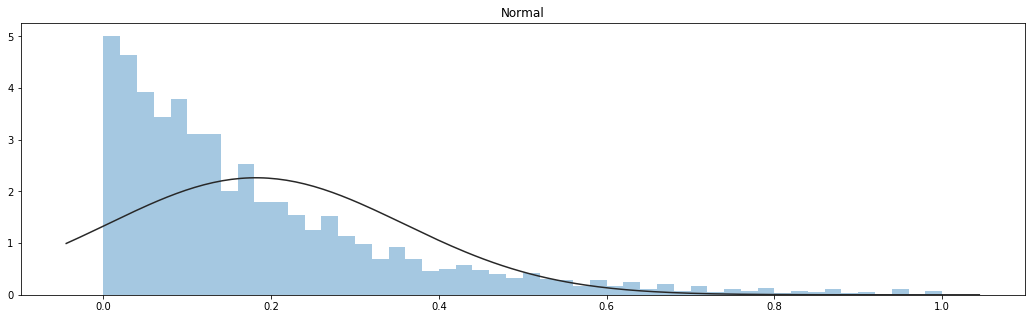

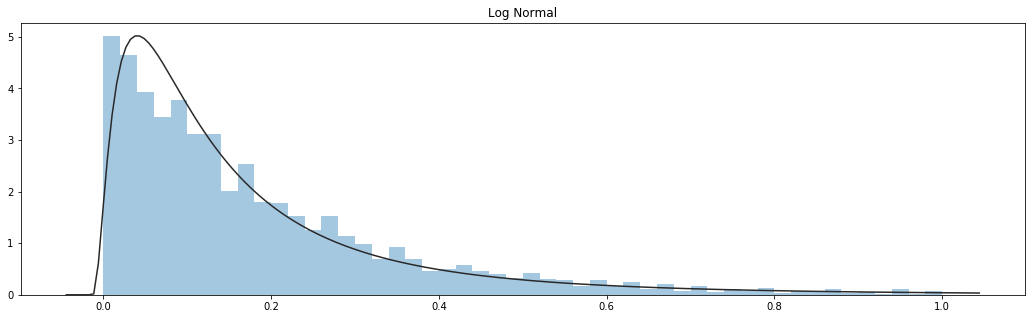

In [15]:
y = (y_train-y_train.min())/(y_train.max() - y_train.min())

plt.figure(1, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(2, figsize = [18,5]); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

plt.show()

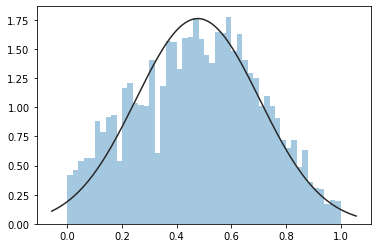

In [16]:
#log + standardization
newPrice = np.log(y_train)
newPrice = (newPrice-newPrice.min())/\
                            (newPrice.max()-newPrice.min())
sns.distplot(newPrice, kde=False, fit=stats.norm)
plt.show()

## Metros totales

In [49]:
cleanedData['metrostotales'] = list(map(lambda x : abs(float(str(x).replace(',','.'))),\
                                        cleanedData['metrostotales'].values))

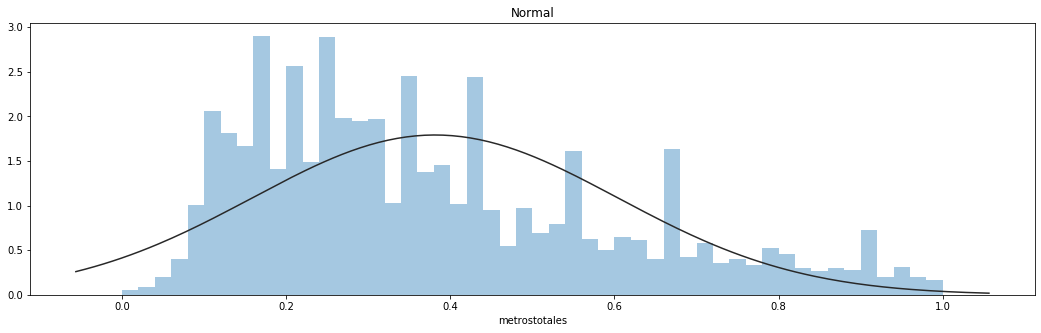

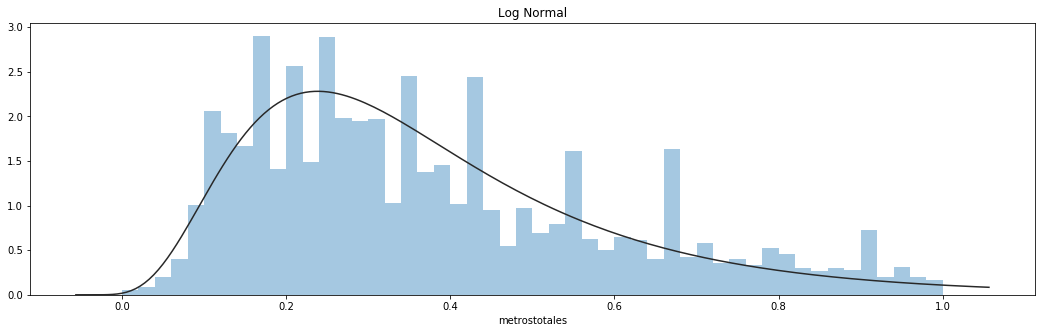

In [56]:
y = cleanedData['metrostotales'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(3, figsize = [18,5]); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

plt.show()

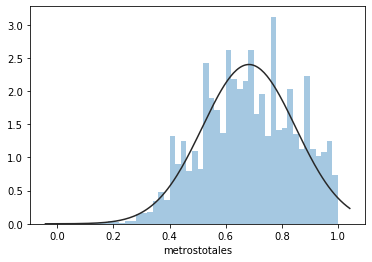

In [58]:
#log + standardization
y = cleanedData['metrostotales'].dropna()
y = np.log(1 + y) #PORQUE LE SUMA 1 ???????
y = (y - y.min()) / (y.max() - y.min())

sns.distplot(y, kde=False, fit=stats.norm)
plt.show()

## Metros Cubiertos

In [60]:
cleanedData['metroscubiertos'] = list(map(lambda x : abs(float(str(x).replace(',','.'))), cleanedData['metroscubiertos'].values))

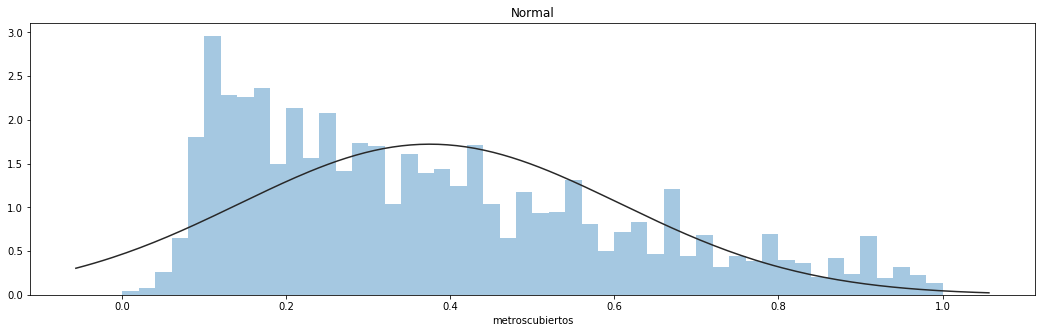

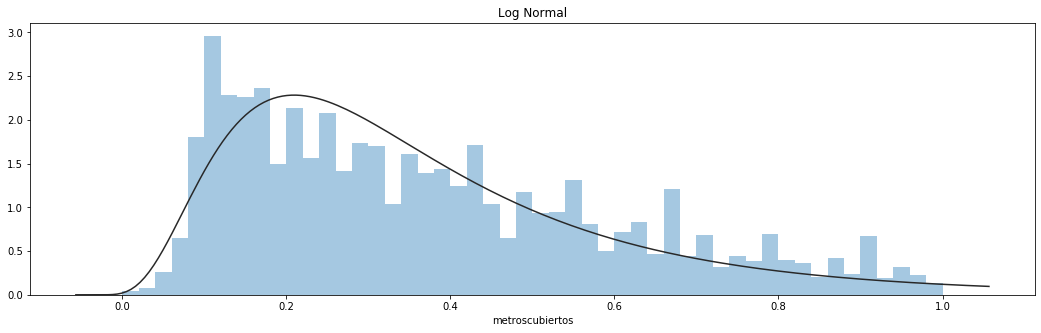

In [61]:
y = cleanedData['metroscubiertos'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(3, figsize = [18,5]); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

plt.show()

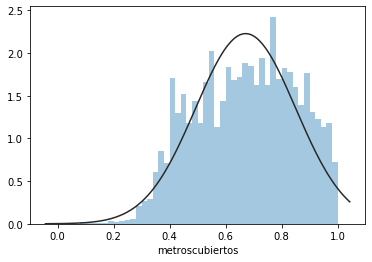

In [62]:
#log + standardization
y = cleanedData['metroscubiertos'].dropna()
y = np.log(1 + y) #PORQUE LE SUMA 1 ???????
y = (y - y.min()) / (y.max() - y.min())

sns.distplot(y, kde=False, fit=stats.norm)
plt.show()

In [ ]:
#Antiguedad

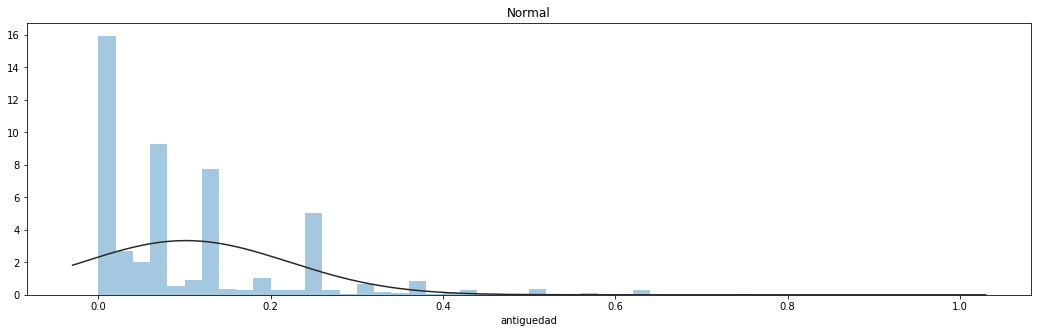

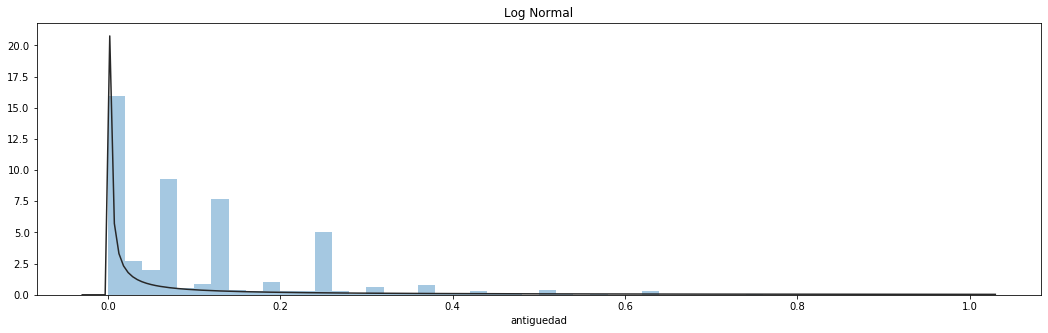

In [64]:
y = cleanedData['antiguedad'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(3, figsize = [18,5]); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

plt.show()

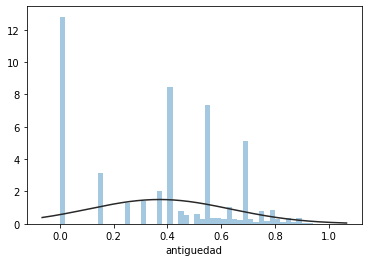

In [67]:
#log + standardization
y = cleanedData['antiguedad'].dropna()
y = np.log(1 + y) #PORQUE LE SUMA 1 ???????
y = (y - y.min()) / (y.max() - y.min())

sns.distplot(y, kde=False, fit=stats.norm)
plt.show()

## Banos - Habitaciones - Garages

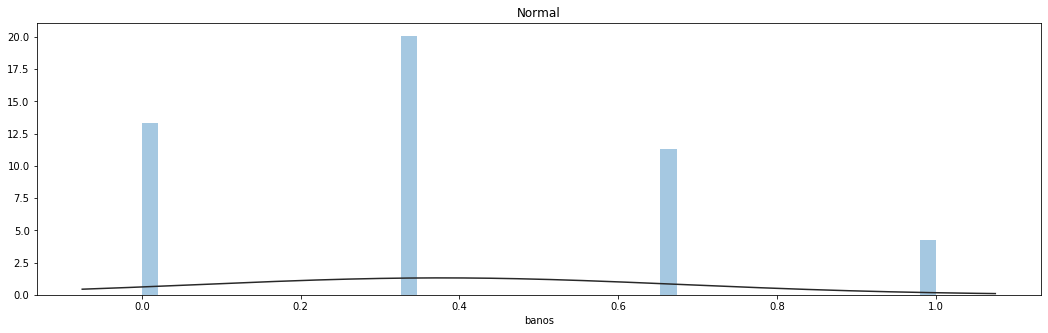

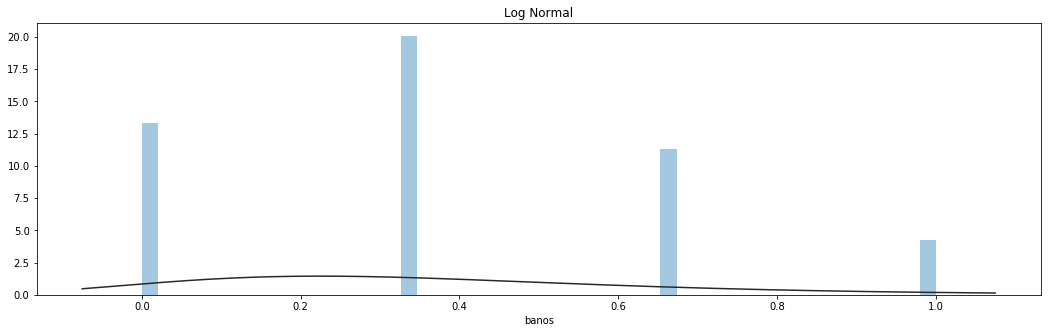

In [69]:
#only min max scaler

y = cleanedData['banos'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.show()

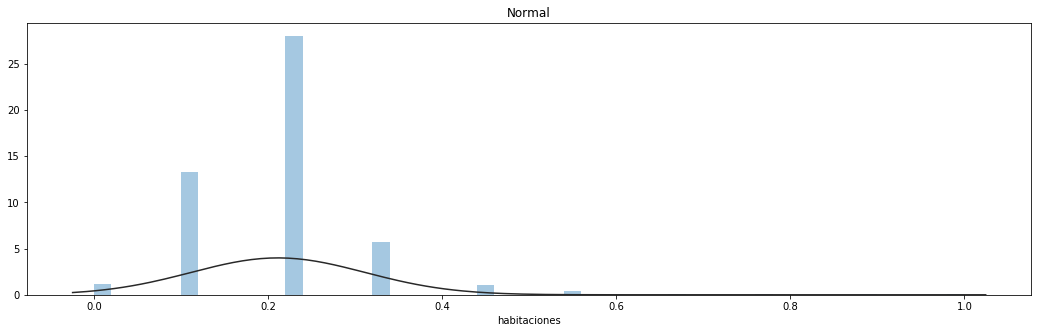

In [70]:
#only min max scaler

y = cleanedData['habitaciones'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.show()

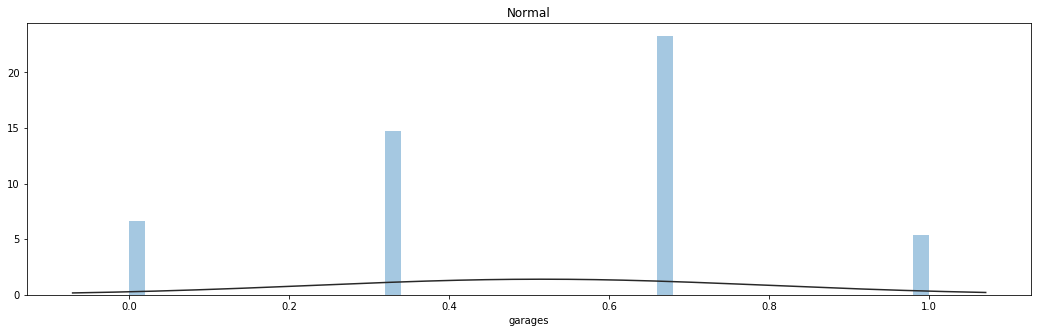

In [71]:
#only min max scaler

y = cleanedData['garages'].dropna()
y = (y - y.min()) / (y.max() - y.min())

plt.figure(2, figsize = [18,5]); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.show()

In [ ]:
# QUEDAN LAS VARIABLES CATEGORICAS: ciudad, tipodepropiedad, provincia

# SE PUEDE ELEGIR UN TIPO DE ENCODING EL CUAL VA A SERVIR PARA MEJORAR LA PERFORMANCE DE UN MODELO DE ML
# DEPENDIENDO EL MODELO LA TECNICA DE ENCODING ELEGIDA PUEDE CAMBIAR.
# 
# 